In [1]:
import os
import sys
import tqdm
import torch
import numpy as np
import pandas as pd
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from dataset import CustomDataset
from sklearn.manifold import TSNE
from dataloader import load_ML100K
from torch.autograd import Variable
from ml100k_pyg_loader import ML100k
import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from model import Discriminator
from torch_geometric.nn import MetaPath2Vec

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = ML100k('../data/ml-100k')
hg = dataset[0]
hg

Using existing file ml-100k.zip


HeteroData(
  user={
    num_nodes=943,
    user_index=[943],
    gender=[943],
    age=[943],
    occupation=[943],
    zip_code=[943]
  },
  movie={
    num_nodes=1682,
    user_index=[1682],
    genre=[1682]
  },
  (user, rates, movie)={
    edge_index=[2, 100000],
    edge_rating=[100000],
    edge_timestamp=[100000]
  }
)

In [2]:
hg = T.ToUndirected()(hg)
metapatorch = [
    ('user', 'rates', 'movie'),
    ('movie', 'rev_rates', 'user'),
]
hg

HeteroData(
  user={
    num_nodes=943,
    user_index=[943],
    gender=[943],
    age=[943],
    occupation=[943],
    zip_code=[943]
  },
  movie={
    num_nodes=1682,
    user_index=[1682],
    genre=[1682]
  },
  (user, rates, movie)={
    edge_index=[2, 100000],
    edge_rating=[100000],
    edge_timestamp=[100000]
  },
  (movie, rev_rates, user)={
    edge_index=[2, 100000],
    edge_rating=[100000],
    edge_timestamp=[100000]
  }
)

In [3]:
metapath2vec = MetaPath2Vec(hg.edge_index_dict, embedding_dim=128,
                     metapath=metapatorch, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = metapath2vec.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(metapath2vec.parameters()), lr=0.01)
epochs = 10
metapath2vec.train()
for epoch in range(0, epochs):
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = metapath2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        print('\r',f'Epoch: {epoch+1} of {epochs}, Step: {i + 1:.3f}/{len(loader)}, 'f'Loss: {loss:.3f}', end=' ')

 Epoch: 10 of 10, Step: 8.000/8, Loss: 3.166 

In [4]:
embedding_dict = {}
for node_type in metapath2vec.num_nodes_dict:
    # get embedding of node witorch specific type
    embedding_dict[node_type] = metapath2vec(node_type).detach().cpu()
    print(node_type, embedding_dict[node_type].shape)

user torch.Size([943, 128])
movie torch.Size([1682, 128])


/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-scor

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        15
         1.0       0.00      0.00      0.00         6
         2.0       0.00      0.00      0.00         0
         3.0       0.07      0.14      0.10        14
         4.0       0.17      0.12      0.14        16
         5.0       0.00      0.00      0.00         5
         6.0       0.00      0.00      0.00         6
         7.0       0.00      0.00      0.00         4
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         3
        10.0       0.00      0.00      0.00        16
        11.0       0.20      0.17      0.18         6
        12.0       0.00      0.00      0.00         1
        13.0       0.22      0.17      0.20        23
        14.0       0.05      0.06      0.05        17
        15.0       0.00      0.00      0.00         3
        16.0       0.00      0.00      0.00         2
        17.0       0.00    

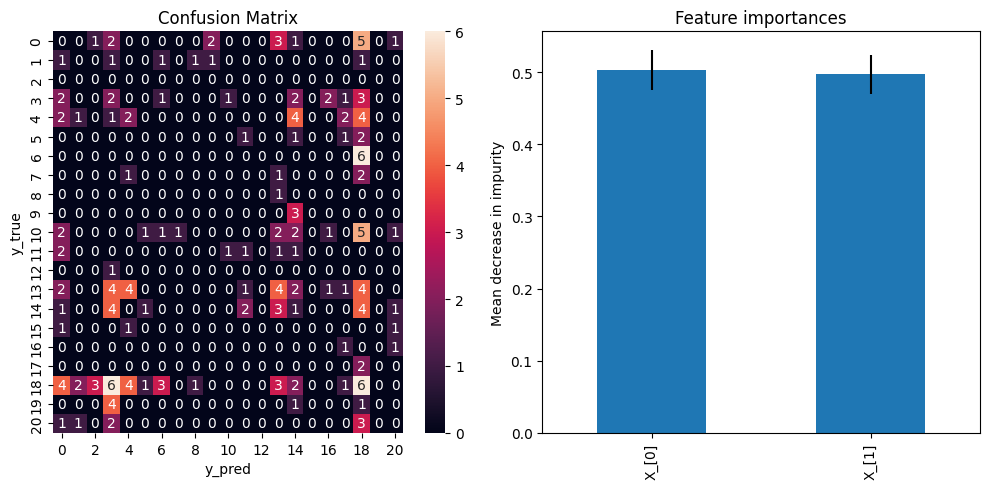

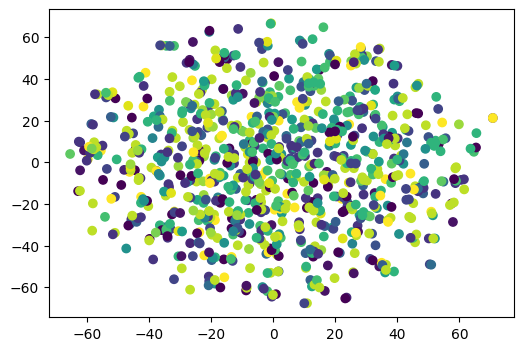

In [5]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2, init='random', perplexity=3).fit_transform(embedding_dict['user'])
# X=embedding_dict['user']
y_true = hg['user'].occupation.float()
# importing necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# splitting X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y_true,test_size=.2)

# # training a ML classifier

feature_names = [f"X_{[i]}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
# clf = DecisionTreeClassifier()
y_pred = forest.predict(X_test)

# creating a figure for plotting
fig = plt.figure(figsize=(10,5))
ax1= fig.add_subplot(121)

# creating a confusion matrix
cm =  confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True).plot()
ax1.set_title("Confusion Matrix")
ax1.set_ylabel("y_true")
ax1.set_xlabel("y_pred")

# creating feature importances
ax2 = fig.add_subplot(122)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.plot.bar(yerr=std, ax=ax2)
ax2.set_title("Feature importances")
ax2.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print(classification_report(y_test, y_pred))

fig = plt.figure(figsize=(6,4))
# Embedding plot
if X.shape[1] > 2:
    print('3d')
    ax_emb = fig.add_subplot(projection='3d')
    ax_emb.scatter(X[:,0],X[:,1],X[:,2], c=y_true)
else:
    ax_emb = fig.add_subplot()# create axes
    ax_emb.scatter(X[:,0],X[:,1], c=y_true)
    
plt.show()

In [14]:
from torch_geometric.utils import index_to_mask
from sklearn.manifold import TSNE

args={
    'activation':'softmax',
    'num_workers':0,
    'batch_size':128,
    'criterion':'CELoss',
    'optimizer':'adam',
    'epochs':100
}
print(len(y_true.unique()))
if len(y_true.unique()) == 2:
    args['out_dim'] = 1
else:
    args['out_dim'] = len(y_true.unique())


X = TSNE(n_components=2, init='random', perplexity=3).fit_transform(embedding_dict['user'])
X = torch.tensor(X)
y_true = hg['user'].occupation.float()
entities=np.array(range(X.shape[0]))
num_ents = len(entities)
cutoff = int(np.round(entities.shape[0]*.9))
train_set = CustomDataset(entities[:cutoff])
test_set = CustomDataset(entities[cutoff:])
discriminator=Discriminator(hidden_dim = 2, out_dim=args['out_dim'], activation=get_activation(args['activation']), num_layers=2, dropout=0.3, relu = 0.2)
train_loader = DataLoader(train_set, num_workers=args['num_workers'], batch_size=args['batch_size'])
test_loader = DataLoader(test_set, num_workers=args['num_workers'], batch_size=args['batch_size'])
loss_fn = get_criterion(args['criterion'])
opt = get_optimizer(args['optimizer'],discriminator.parameters())

21


/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [16]:
from utils import get_roc_auc
def test_discriminator(test_loader,discriminator, y_true, num_ents):
    probs_list, labels_list = [], []
    for p_batch in test_loader:
        p_batch_var = Variable(p_batch).to(device)
        mask=index_to_mask(p_batch_var, num_ents)
        p_batch_emb=X[mask].detach()
        y_hat = discriminator(p_batch_emb)
        y = Variable(torch.FloatTensor(y_true[mask].detach())).to(device)
        probs_list.append(y_hat)
        labels_list.append(y)
    Y = torch.cat(labels_list,0)
    Y_hat = torch.cat(probs_list,0)
    loss = loss_fn(Y_hat,Y)
    auc = get_roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy(), name='multi')
    return loss, auc

discriminator.eval()
dataloader=tqdm.tqdm(range(1, args['epochs']+1))
train_loss_vals, test_loss_vals = [], []
train_auc_vals, test_auc_vals = [], []
for epoch in dataloader:
    probs_list, labels_list = [], []
    for p_batch in train_loader:
        p_batch_var = Variable(p_batch).to(device)
        mask=index_to_mask(p_batch_var, num_ents)
        p_batch_emb=X[mask].detach()
        y_hat = discriminator(p_batch_emb)
        y = Variable(torch.FloatTensor(y_true[mask].detach())).to(device)
        probs_list.append(y_hat)
        labels_list.append(y)
        loss = loss_fn(y_hat,y)
        opt.zero_grad()
        loss.backward()
        opt.step()

    Y = torch.cat(labels_list,0)
    Y_hat = torch.cat(probs_list,0)
    print(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy())
    train_auc = get_roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy(), name='multi')
    train_loss = loss_fn(Y_hat, Y)
    test_loss, test_auc = test_discriminator(test_loader, discriminator, y_true, num_ents)
    train_loss_vals.append(train_loss.item())
    test_loss_vals.append(test_loss.item())
    train_auc_vals.append(train_auc.item())
    test_auc_vals.append(test_auc.item())
    dataloader.set_description(
        f'Train Loss: {train_loss:.2f}, \
        Train AUC: {train_auc:.2f}, Test Loss: {test_loss:.2f}, \
        Test AUC: {test_auc:.2f}'
    )

  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]


RuntimeError: expected scalar type Long but found Float